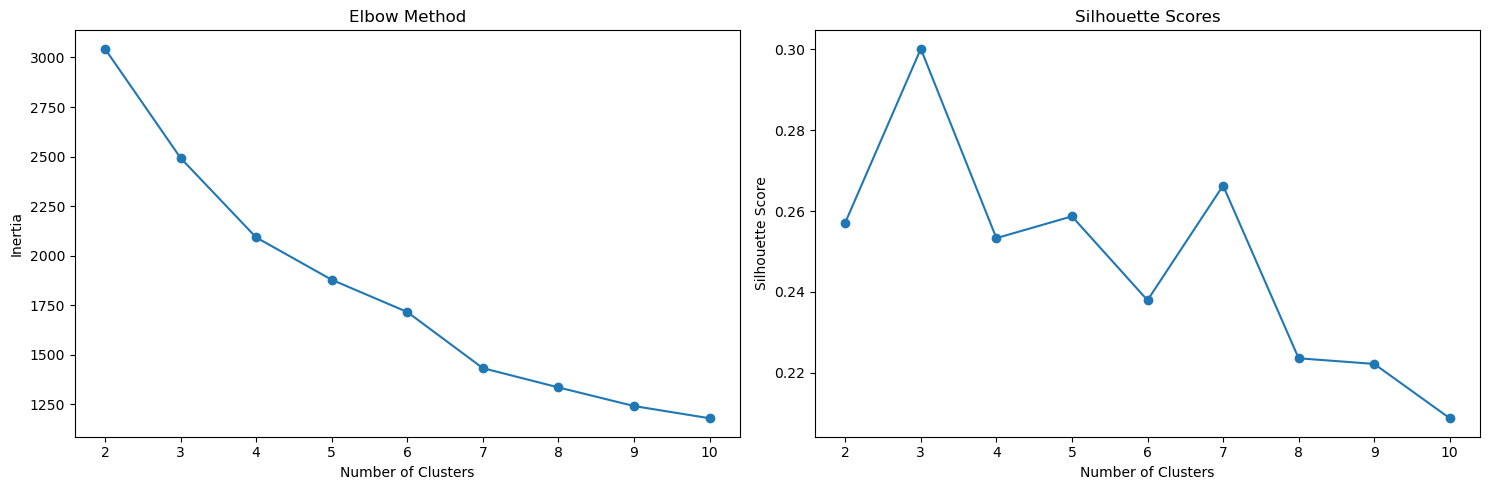

IndexError: index 6 is out of bounds for axis 0 with size 6

<Figure size 2000x1500 with 0 Axes>

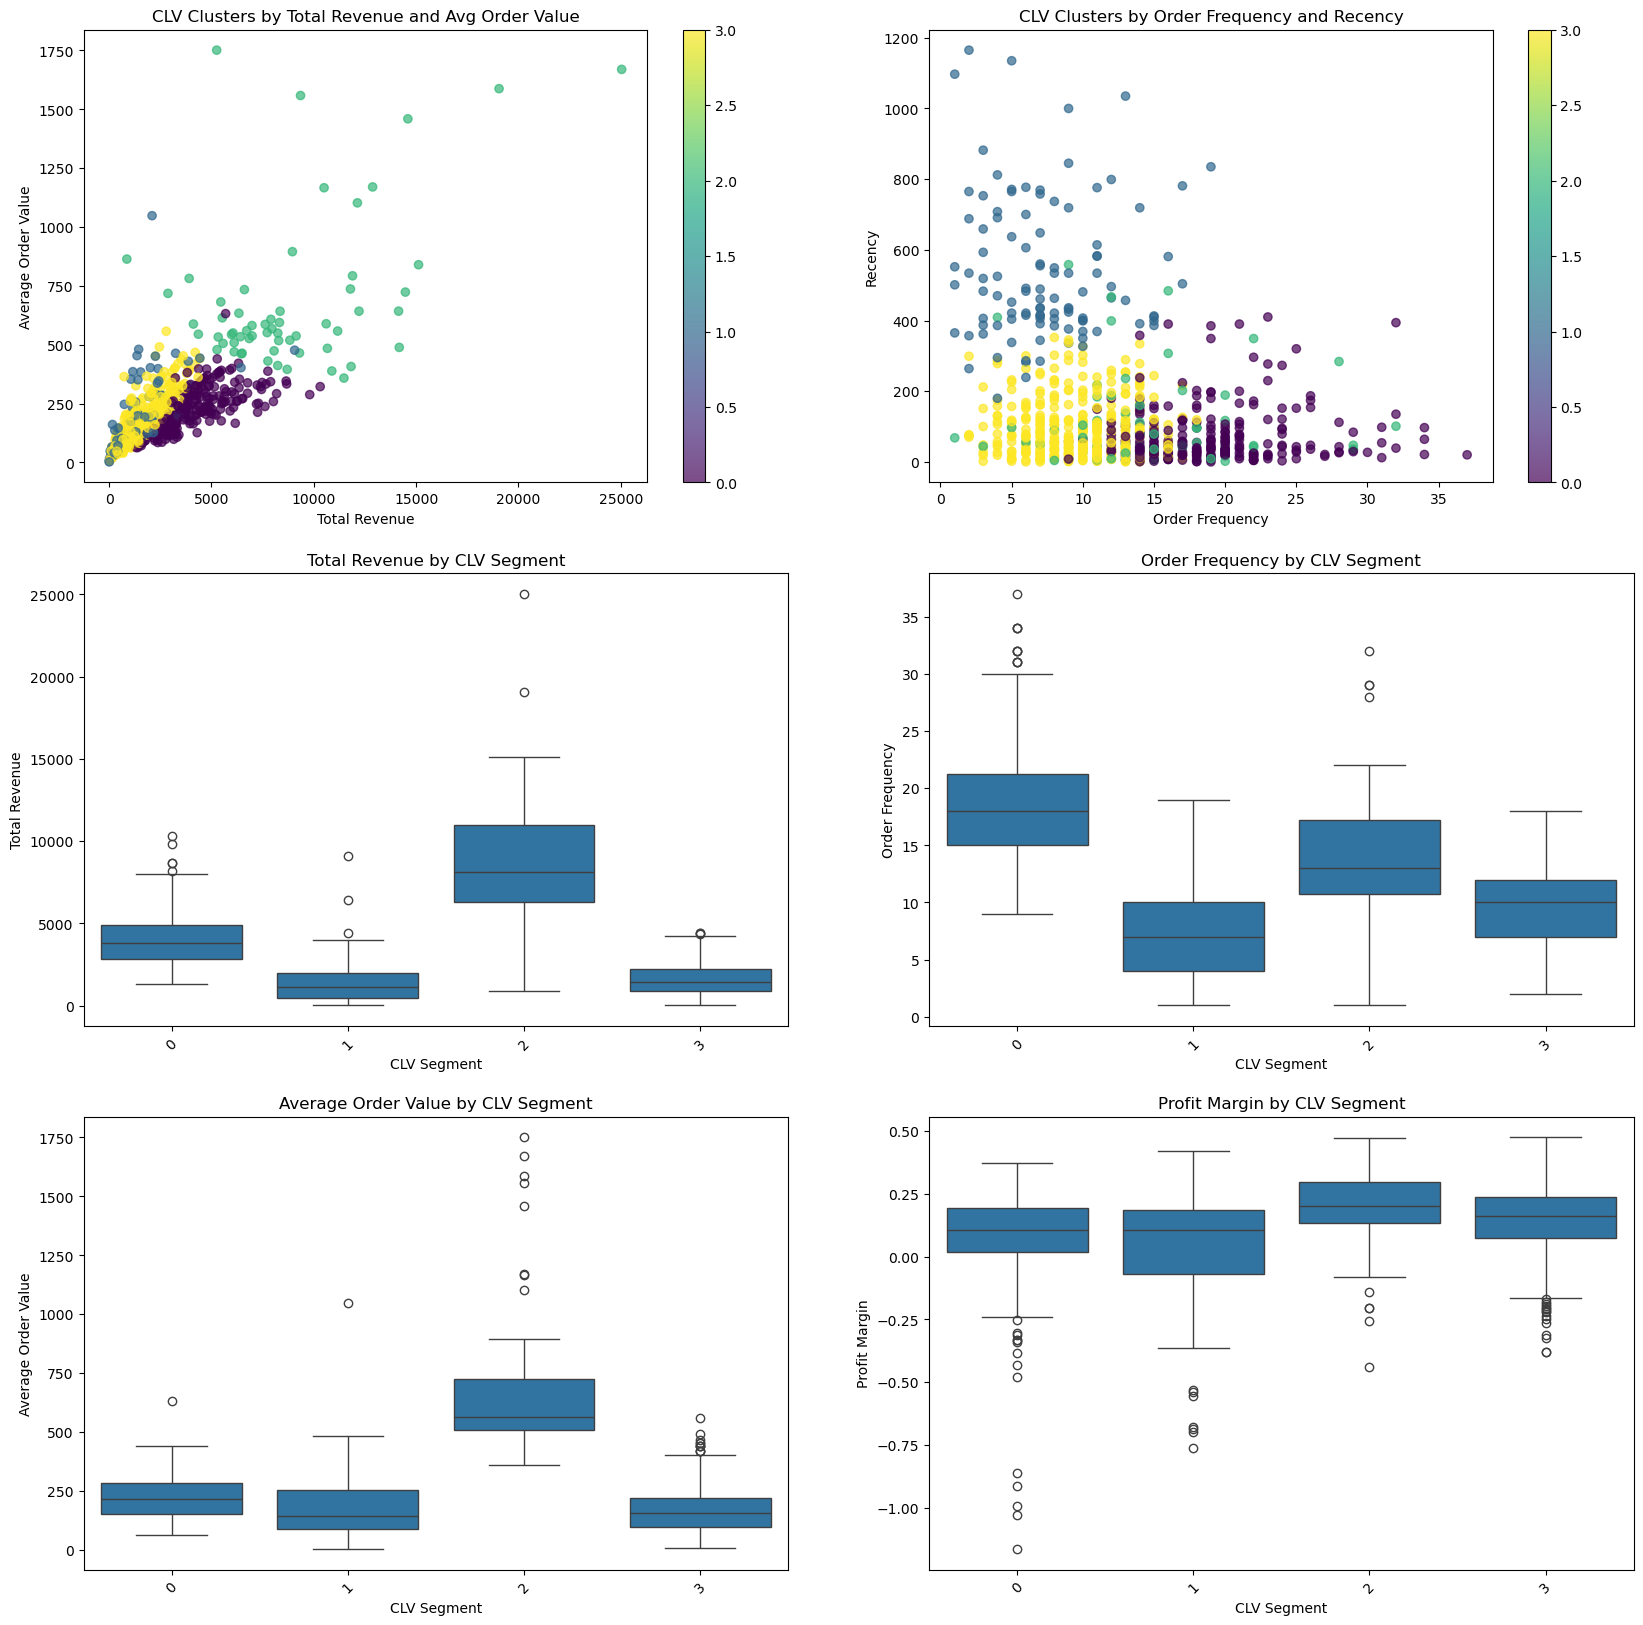

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Read the dataset
df = pd.read_csv('superstore.csv', encoding='cp1252')

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Calculate Customer Lifetime Value (CLV) Components
# Aggregate customer-level data
customer_revenue = df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'count',
    'Order Date': 'max'
}).reset_index()

# Rename columns
customer_revenue.columns = ['Customer ID', 'Total Revenue', 'Total Profit', 'Order Frequency', 'Last Purchase Date']

# Calculate Customer Tenure
latest_date = df['Order Date'].max()
customer_revenue['Customer Tenure'] = (latest_date - customer_revenue['Last Purchase Date']).dt.days

# Additional metrics
customer_revenue['Average Order Value'] = customer_revenue['Total Revenue'] / customer_revenue['Order Frequency']
customer_revenue['Profit Margin'] = customer_revenue['Total Profit'] / customer_revenue['Total Revenue']
customer_revenue['Recency'] = (latest_date - customer_revenue['Last Purchase Date']).dt.days

# Select features for CLV clustering
clv_features = [
    'Total Revenue', 
    'Order Frequency', 
    'Average Order Value', 
    'Profit Margin', 
    'Recency'
]

# Prepare feature matrix
X = customer_revenue[clv_features]

# Handle potential infinite or NaN values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method and Silhouette Score
plt.figure(figsize=(15, 5))

# Inertia (Elbow Method)
inertias = []
silhouette_scores = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Subplot for Elbow Method
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Subplot for Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Choose optimal number of clusters
optimal_clusters = 4  # Adjust based on the plots

# Perform K-means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_revenue['CLV Segment'] = kmeans.fit_predict(X_scaled)

# Advanced Visualization
plt.figure(figsize=(20, 15))

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Flatten the axes array for easier indexing
axs_flat = axs.flatten()

# Scatter plot 1: Total Revenue vs Average Order Value
scatter1 = axs_flat[0].scatter(customer_revenue['Total Revenue'], 
                                customer_revenue['Average Order Value'], 
                                c=customer_revenue['CLV Segment'], 
                                cmap='viridis', 
                                alpha=0.7)
axs_flat[0].set_title('CLV Clusters by Total Revenue and Avg Order Value')
axs_flat[0].set_xlabel('Total Revenue')
axs_flat[0].set_ylabel('Average Order Value')
plt.colorbar(scatter1, ax=axs_flat[0])

# Scatter plot 2: Order Frequency vs Recency
scatter2 = axs_flat[1].scatter(customer_revenue['Order Frequency'], 
                                customer_revenue['Recency'], 
                                c=customer_revenue['CLV Segment'], 
                                cmap='viridis', 
                                alpha=0.7)
axs_flat[1].set_title('CLV Clusters by Order Frequency and Recency')
axs_flat[1].set_xlabel('Order Frequency')
axs_flat[1].set_ylabel('Recency')
plt.colorbar(scatter2, ax=axs_flat[1])

# Box plots for features
for i, feature in enumerate(clv_features, 2):
    sns.boxplot(x='CLV Segment', y=feature, data=customer_revenue, ax=axs_flat[i])
    axs_flat[i].set_title(f'{feature} by CLV Segment')
    axs_flat[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Cluster Characteristics
clv_segment_summary = customer_revenue.groupby('CLV Segment')[clv_features].mean()
print("\nCLV Segment Characteristics:")
print(clv_segment_summary)

# Estimated CLV for each segment
clv_segment_summary['Estimated CLV'] = (
    clv_segment_summary['Total Revenue'] / 
    clv_segment_summary['Recency'] * 
    365  # Annualized
)

print("\nEstimated Customer Lifetime Value by Segment:")
print(clv_segment_summary['Estimated CLV'])

# Optional: Detailed segment analysis
detailed_analysis = customer_revenue.groupby('CLV Segment').agg({
    'Customer ID': 'count',
    'Total Revenue': ['mean', 'min', 'max'],
    'Order Frequency': ['mean', 'min', 'max']
})
print("\nDetailed Segment Analysis:")
print(detailed_analysis)